[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/probabilistic_python/blob/master/pymc_intro.ipynb)

# Building Models in PyMC


Probabilistic programming (PP) allows flexible specification of Bayesian statistical models in code. PyMC is an open-source PP framework with an intuitive and readable, yet powerful, syntax that is close to the natural syntax statisticians use to describe models. It features next-generation Markov chain Monte Carlo (MCMC) sampling algorithms such as the No-U-Turn Sampler (NUTS; Hoffman, 2014), a self-tuning variant of Hamiltonian Monte Carlo (HMC; Duane, 1987). This class of samplers works well on high dimensional and complex posterior distributions and allows many complex models to be fit without specialized knowledge about fitting algorithms. HMC and NUTS take advantage of gradient information from the likelihood to achieve much faster convergence than traditional sampling methods, especially for larger models. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo, which means you usually don't need to have specialized knowledge about how the algorithms work. 

Let's start by looking at a real-world problem, to give you an idea of how to build a model in PyMC.


In [1]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
# import aesara.tensor as at
import pytensor.tensor as pt
from IPython.display import Video

random_seed = 42
DATA_URL = "https://raw.githubusercontent.com/fonnesbeck/probabilistic_python/master/data/"

In [2]:
import jax
jax.default_backend()

'cpu'

## Example: The MLB "Sticky Stuff" Incident

Since the earliest days of the sport, baseball pitchers have applied foreign substances on the ball to help them throw better pitchers. But while it has always been against the rules, is was rarely enforced. In the early days, pine tar was used to allow for a harder grip on the ball, which in turn allows the ball to be spun at a higher rate. Eventually, this evolved to a sticky blend of rosin (powder derived from pine tree sap) and sunscreen. The resulting high spin rates resulted in fewer hits and more strikeouts, and finally led  MLB to a mid-season crackdown in 2021, handing out 10-game suspensions to any pitcher caught using "sticky stuff":

> Any pitcher who possesses or applies foreign substances will be subject to immediate ejection from the game and suspended automatically in accordance with the rules. If a player other than the pitcher is found to have applied a foreign substance to the ball, both the position player and pitcher will be ejected.

In [3]:
# Video(url='assets/nola_cb.mp4') 

![](assets/sticky_stuff_scherzer.jpg)

With the advent of remote sensing data, it is possible to track the spin rates (and other metrics) of pitched balls. This data is freely available from the [MLB Advanced Media website](https://baseballsavant.mlb.com/). 

Can we formulate a model to detect any changes in spin rate that are might be attributable to stepped-up enforcement of sticky stuff?

> ... word of its arrival trickled out around June 3, as MLB made it known it planned to increase scrutiny amid record-high strikeout rates. (Washington Post)

The dataset below includes all curve balls thrown by pitchers during the 2021 season.

In [4]:
try:
    spin_rate_data = pd.read_csv('./data/savant_data.csv', parse_dates=['game_date']).dropna(subset=['spin_rate', 'game_date'])
except FileNotFoundError:
    spin_rate_data = pd.read_csv(DATA_URL + 'savant_data.csv', parse_dates=['game_date']).dropna(subset=['spin_rate', 'game_date'])

spin_rate_data.head()

,pitches,player_id,player_name,game_date,total_pitches,pitch_percent,ba,iso,babip,slg,...,takes,eff_min_vel,release_extension,pos3_int_start_distance,pos4_int_start_distance,pos5_int_start_distance,pos6_int_start_distance,pos7_int_start_distance,pos8_int_start_distance,pos9_int_start_distance
0,47,450203,"Morton, Charlie",2021-07-16,107,43.9,0.077,0.077,0.167,0.154,...,28,0.1,6.36,111.0,148.0,139.0,134.0,299.0,320.0,300.0
1,47,621244,"Berríos, José",2021-05-08,104,45.2,0.143,0.286,0.143,0.429,...,28,-0.2,6.31,101.0,148.0,112.0,145.0,295.0,332.0,297.0
2,46,450203,"Morton, Charlie",2021-06-17,112,41.1,0.000,0.000,0.000,0.000,...,20,-0.4,6.21,105.0,151.0,134.0,137.0,314.0,322.0,291.0
3,45,450203,"Morton, Charlie",2021-08-31,106,42.5,0.100,0.000,0.143,0.100,...,26,-0.4,6.16,114.0,153.0,139.0,143.0,296.0,317.0,298.0
4,45,450203,"Morton, Charlie",2021-06-22,107,42.1,0.000,0.000,NaN,0.000,...,27,-0.8,6.28,107.0,149.0,135.0,135.0,290.0,304.0,291.0


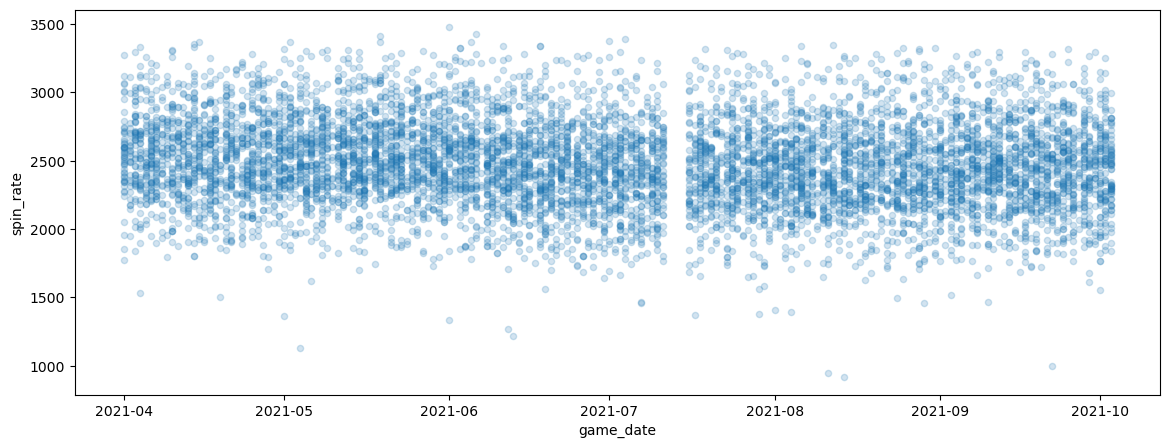

In [5]:
spin_rate_data.plot.scatter(x='game_date', y='spin_rate', figsize=(14,5), alpha=0.2);

We only need two columns from this dataset: the **spin rates** of each pitch, and the **dates** on which they were thrown.

In [6]:
day_ind, date = pd.factorize(spin_rate_data.game_date, sort=True)
spin_rate = spin_rate_data.spin_rate.values

## The Model

To represent the hypothesis that spin rates differed before and after the MLB crackdown on sticky stuff, we will implement a **changepoint model**. In its simplest form, this is a piecewise-constant model, with an early and late population mean, separated by a discrete changepoint. The challenge here is that we want to assume that the changepoint is unknown, use the data to estimate its location, and then see whether the estimated changepoint is consistent with the change in enforcement.

How can we represent this observation mathematically? Let's assume that on some day during the observation period (call it τ), the parameter $\mu$ suddenly jumps to a lower value:

$$
r_t=\left\{
\begin{array}{lll}             
\mu_1 &\text{if}& t \lt \tau \\ 
\mu_2 &\text{if}& t \ge \tau             
\end{array}\right.
$$

The pitch spin rates on either side of the changepoint can then be modeled as normally-distributed with either the early or late mean. These are our sampling distributions, or likelihoods.

$$
y_i^{(pre)} \sim \text{Normal}(\mu_1, \sigma) \\
y_i^{(post)} \sim \text{Normal}(\mu_2, \sigma)
$$


### Stochastic and Deterministic Variables

At the model-specification stage (before the data are observed), $\mu_1$, $\mu_2$, $\tau$ and $\sigma$ are all random variables. Bayesian "random" variables have not necessarily arisen from a physical random process. The Bayesian interpretation of probability is **epistemic**, meaning random variable $x$'s probability distribution $p(x)$ represents our knowledge and uncertainty about $x$'s value. Candidate values of $x$ for which $p(x)$ is high are relatively more probable, given what we know. 

We can generally divide the variables in a Bayesian model into two types: **stochastic** and **deterministic**. The only deterministic variable in this model is $r_t$. If we knew the values of $r_t$'s parents, we could compute the value of $r_t$ exactly. A deterministic like $r_t$ is defined by a mathematical function that returns its value given values for its parents. Deterministic variables are sometimes called the *systemic* part of the model. The nomenclature is a bit confusing, because these objects usually represent random variables; since the parents of $r_t$ are random, $r_t$ is random also.

On the other hand, even if the values of the parents of $\mu_1$, for example, were known, we would still be uncertain of its value. Such variables are stochastic, characterized by probability distributions that express how plausible their candidate values are, given values for their parents.

We will assign the following **prior distributions** to our stochastic variables:

$$\mu_i \sim \text{Normal}(2500, 100)$$

$$\tau \sim \text{Uniform}(0, T)$$

$$\sigma \sim \text{HalfNormal}(100)$$

## Implementation

Now that we have written the model down completely, let's turn it into PyMC code. We will walk through it step-by-step, from specifying our prior distributions through to the data likelihoods.

In [7]:
with pm.Model() as spin_rate_model:

    mu = pm.Normal('mu', mu=2500, sigma=100, shape=2)
    tau = pm.Uniform('tau', lower=day_ind.min(), upper=day_ind.max())

We have done two things here. First, we have created a `Model` object; a `Model` is a Python object that encapsulates all of the variables that comprise our theoretical model, keeping them in a single container so that they may be used as a unit. After a `Model` is created, we can populate it with all of the model components that we specified when we wrote the model down. 

Notice that the `Model` above was declared using a `with` statement. This expression is used to define a Python idiom known as a **context manager**. Context managers, in general, are used to manage resources of some kind within a program. In this case, our resource is a `Model`, and we would like to add variables to it so that we can fit our statistical model. The key characteristic of the context manager is that the resources it manages are only defined within the indented block corresponding to the `with` statement. PyMC uses this idiom to automatically add defined variables to a model. Thus, any variable we define is automatically added to the `Model`, without having to explicitly add it.

As an analogy, `Model` is a tape machine that records what is being added to the model; it keeps track the random variables (observed or unobserved) and other model components. The model context then computes some simple model properties, builds a **bijection** mapping that transforms between Python dictionaries and numpy/Aesara ndarrays. , More importantly, a `Model` contains methods to compile Aesara functions that take Random Variables--that are also initialised within the same model--as input.

In fact, PyMC variables cannot be defined without a corresponding `Model`:

In [8]:
# x = pm.Normal("x", mu=0, sigma=10)

A stochastic variable is represented in PyMC by a `Distribution` class. This structure extens Aesara's `TensorVariable` class, mainly by registering it with an associated PyMC `Model`. 

In [9]:
# type(early_mean)

All of the `Distribution` subclasses included in PyMC will have two key methods, `random()` and `logp()`, which are used to generate random values and compute the log-probability of a value, respectively.

```python
class SomeDistribution(Continuous):
    def __init__(...):
        ...

    def random(self, point=None, size=None):
        ...
        return random_samples

    def logp(self, value):
        ...
        return total_log_prob
```

PyMC expects the `logp()` method to return a log-probability evaluated at the passed `value` argument. This method is used internally by all of the inference methods to calculate the model log-probability that is used for fitting models. 

The `logp` method is only used internally by PyMC; should you wish to calculate a log-probability manually, use the `pm.logp` function instead:

In [10]:
pm.logp(tau, 5).eval()

array(-5.19849703)

The `random()` method is used to simulate values from the variable, and is used internally for posterior predictive checks. Similarly, to manually generate values from PyMC variables, use the `pm.draw` function:

In [11]:
pm.draw(mu, 5)

array([[2472.7959888 , 2554.73184692],
       [2533.4393644 , 2420.38405879],
       [2453.56208312, 2492.93481088],
       [2390.62919459, 2517.99222764],
       [2336.03654136, 2506.81898118]])

`Distribution` has a classmethod `dist` that returns a **stateless** probability distribution of that type; that is, without being wrapped in a PyMC random variable object. Sometimes we wish to use a particular statistical distribution, without using it as a variable in a model; for example, to generate random numbers from the distribution. 

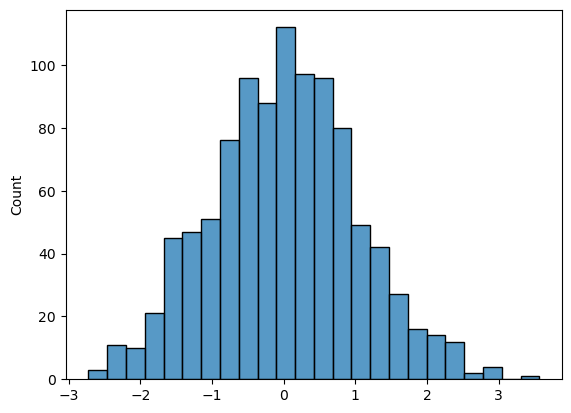

In [12]:
x = pm.Normal.dist(mu=0, sigma=1, size=1000)
sns.histplot(x.eval());

PyMC includes most of the probability density functions (for continuous variables) and probability mass functions (for discrete variables) used in statistical modeling. These distributions are divided into five distinct categories:

* Univariate continuous
* Univariate discrete
* Multivariate
* Mixture
* Timeseries

Probability distributions are all subclasses of `Distribution`, which in turn has two major subclasses: `Discrete` and `Continuous`. In terms of data types, a `Continuous` random variable is given whichever floating point type is defined by `aesara.config.floatX`, while `Discrete` variables are given `int16` types when `aesara.config.floatX` is `float32`, and `int64` otherwise.

In [13]:
pm.distributions.__all__

['AR',
 'CAR',
 'GARCH11',
 'ICAR',
 'AsymmetricLaplace',
 'Bernoulli',
 'Beta',
 'BetaBinomial',
 'Binomial',
 'Categorical',
 'Cauchy',
 'Censored',
 'ChiSquared',
 'Continuous',
 'CustomDist',
 'DensityDist',
 'DiracDelta',
 'Dirichlet',
 'DirichletMultinomial',
 'Discrete',
 'DiscreteUniform',
 'DiscreteWeibull',
 'Distribution',
 'EulerMaruyama',
 'ExGaussian',
 'Exponential',
 'Flat',
 'Gamma',
 'GaussianRandomWalk',
 'Geometric',
 'Gumbel',
 'HalfCauchy',
 'HalfFlat',
 'HalfNormal',
 'HalfStudentT',
 'HurdleGamma',
 'HurdleLogNormal',
 'HurdleNegativeBinomial',
 'HurdlePoisson',
 'HyperGeometric',
 'Interpolated',
 'InverseGamma',
 'KroneckerNormal',
 'Kumaraswamy',
 'LKJCholeskyCov',
 'LKJCorr',
 'Laplace',
 'LogNormal',
 'Logistic',
 'LogitNormal',
 'Lognormal',
 'MatrixNormal',
 'Mixture',
 'Moyal',
 'Multinomial',
 'MvGaussianRandomWalk',
 'MvNormal',
 'MvStudentT',
 'MvStudentTRandomWalk',
 'NegativeBinomial',
 'Normal',
 'NormalMixture',
 'OrderedLogistic',
 'OrderedMultin

Notice that while the `mu` variable is osensibly a univariate random variable, being normal, it has a shape of 2, meaning that it is a "batch" of similar random variables (i.e. linear model coefficients).

In [14]:
mu.shape.eval()

array([2])

While we are defining our priors, let's also add the prior for `sigma`, the observation noise parameter.

In [15]:
with spin_rate_model:

    sigma = pm.HalfNormal("sigma", 100.)

Notice that we have "re-opened" the `spin_rate_model` in a new context manager, which allows us to add additional variables.

Internally, the model is keeping track of the types of variables that are being added:

In [16]:
spin_rate_model.unobserved_RVs

[mu ~ Normal(2.5e+03, 100), tau ~ Uniform(0, 181), sigma ~ HalfNormal(0, 100)]

### Auto-transformation

To support efficient sampling by PyMC's MCMC algorithms, any continuous variables that are constrained to a sub-interval of the real line are automatically transformed so that their support is unconstrained. This frees sampling algorithms from having to deal with boundary constraints.

For example, the half-normal distribution is positive-valued.

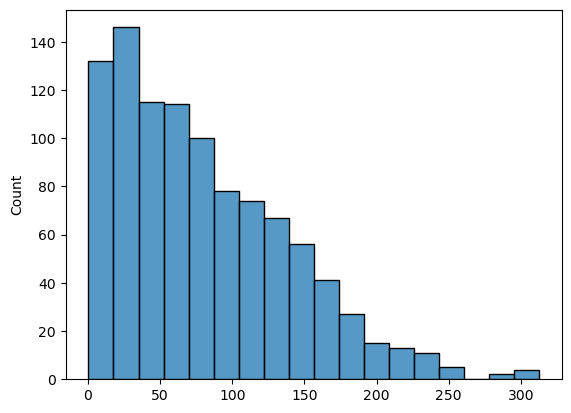

In [17]:
sns.histplot(pm.draw(sigma, 1000));

In [18]:
pm.logp(sigma, -1).eval()

array(-inf)

If we inspect the model's `value_vars` attribute, which contains the values of each random variable actually used by the model's log-likelihood:


In [19]:
spin_rate_model.value_vars

[mu, tau_interval__, sigma_log__]

As the name suggests, the variable `sigma` has been log-transformed, and this is the space over which posterior sampling takes place. When a sample is drawn, the value of the transformed variable is simply back-transformed to recover the original variable.

By default, auto-transformed variables are ignored when summarizing and plotting model output, since they are not generally of interest to the user.

## Deterministic Variables

A deterministic variable is one whose values are **completely determined** by the values of their parents. The values or `r` are assigned based on the values of `tau` and `mu` only, with no inherent randomness beyond what is inherited from them. 

In [20]:
with spin_rate_model:

    r = pm.math.switch(tau >= day_ind, mu[0], mu[1])

Notice that `r` is **anonymous** as it has not been given a name or a formal PyMC data structure, like the stochastic priors have. It is essentially an **intermediate calculation** in the model, implying that we are not interested in its value when it comes to summarizing the output from the model. Most PyMC objects have a name assigned; these names are used for storage and post-processing:

-   as keys in output databases,
-   as axis labels in plots of traces,
-   as table labels in summary statistics.

If we wish to include `r` in our output, we need to make it a `Deterministic` object, and give it a name:

```python
with weibull_model:

    r = pm.Deterministic('r', pm.math.switch(tau >= day_ind, mu[0], mu[1]))
```

In [21]:
r.shape.eval()

array([7791])

## Observed Random Variables

Stochastic random variables whose values are observed (*i.e.* data likelihoods) are represented by a different class than unobserved random variables. A `ObservedRV` object is instantiated any time a stochastic variable is specified with data passed as the `observed` argument. 

In [22]:
with spin_rate_model:

    spin_rate_like = pm.Normal('spin_rate_like', mu=r, sigma=sigma, observed=spin_rate) 

In [23]:
spin_rate_model.observed_RVs

[spin_rate_like ~ Normal(f(tau, mu), sigma)]

An important responsibility of `ObservedRV` is to automatically handle missing values in the data, when they are present (absent?). 

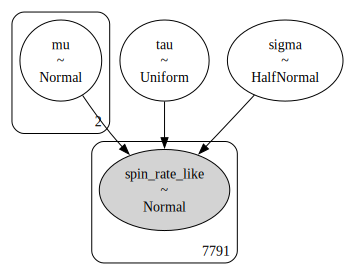

In [24]:
pm.model_to_graphviz(spin_rate_model)

In [ ]:
with spin_rate_model:

    trace = pm.sample(nuts_sampler='numpyro')

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, sigma]


Output()

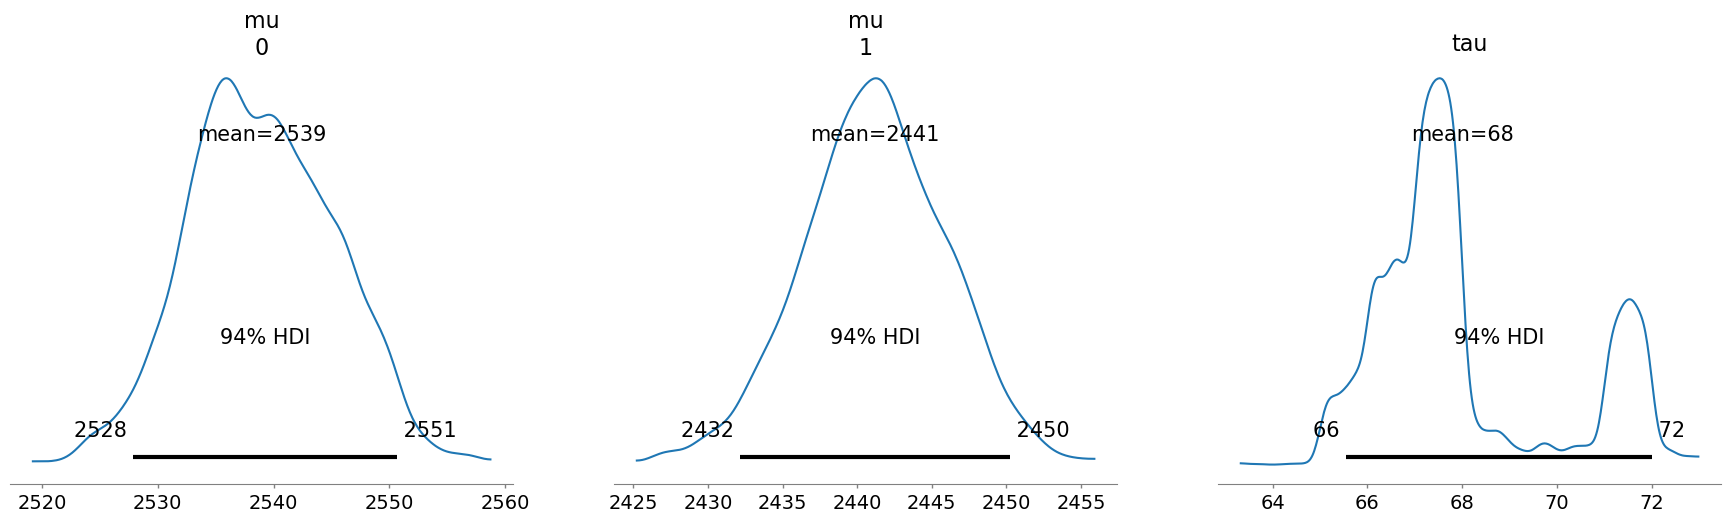

In [ ]:
az.plot_posterior(trace, var_names=["mu", "tau"]);

In [ ]:
date[68]

Timestamp('2021-06-08 00:00:00')

This is a very simple model of spin rate dynamics. How might we improve this model if we had more time?

---

## To Learn More

- C.D. Pilon. [Probabilistic Programming & Bayesian Methods for Hackers](https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)
- M.I. Jordan. 2004. Graphical models. Statist. Sci., 19(1):140–155.
- **Hoffman, M. D., and A. Gelman. (2014)**. The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo. Journal of Machine Learning Research: JMLR 15 (1): 1593–1623.
